# Ovrlpy analysis tutorial of Xenium mouse brain data

In this notebook, we will use ovrlpy to investigate the [Xenium's mouse brain dataset](https://www.10xgenomics.com/products/xenium-in-situ/mouse-brain-dataset-explorer).

We want to create a signal embedding of the transcriptome, and a vertical signal incoherence map to identify locations with a high risk of containing spatial doublets.


## Loading the data:

in a first step, we want to load the data and define settings and input files

In [1]:
from pathlib import Path

data_folder_path = Path(
    "/dh-projects/ag-ishaque/raw_data/tiesmeys-ovrlpy/Xenium-brain-2024/replicate1"
)

signature_matrix_file = Path(
    "/dh-projects/ag-ishaque/raw_data/Xenium-benchmark/scRNAseq/trimmed_means.csv"
)

result_folder = Path("results")
result_folder.mkdir(exist_ok=True, parents=True)

Import relevant analysis packages

In [2]:
import warnings

import anndata as ad
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from ovrlpy import ovrlp

/dh-projects/ag-ishaque/analysis/malta/envs/envs/ovrlpy/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Set the random seed for reproducibility

In [3]:
import random

random.seed(42)

In [4]:
columns = [
    "x_location",
    "y_location",
    "z_location",
    "feature_name",
    "cell_id",
    "overlaps_nucleus",
    "qv",
]

coordinate_df = pd.read_parquet(
    data_folder_path / "transcripts.parquet", columns=columns
).rename(
    columns={
        "x_location": "x",
        "y_location": "y",
        "z_location": "z",
        "feature_name": "gene",
    }
)
coordinate_df["gene"] = coordinate_df["gene"].str.decode("utf-8")



# remove dummy molecules
coordinate_df = coordinate_df.loc[
    ~coordinate_df["gene"].str.contains("BLANK|NegControl"), coordinate_df.columns
]

coordinate_df["gene"] = coordinate_df["gene"].astype("category")

coordinate_df.head()

x            y          z     gene  cell_id  overlaps_nucleus  \
0  4843.045898  6427.729980  19.068869  Bhlhe40    67490                 1   
1  4844.632812  6223.182617  18.520161    Parm1    67957                 0   
2  4842.943359  6478.310547  18.500109  Bhlhe40    67539                 1   
3  4843.941406  6344.550293  15.016154     Lyz2    68003                 0   
4  4843.162598  6632.111816  15.394680     Dkk3    67344                 0   

          qv  
0  40.000000  
1  40.000000  
2  13.813585  
3  19.471884  
4  40.000000

## Tissue overview

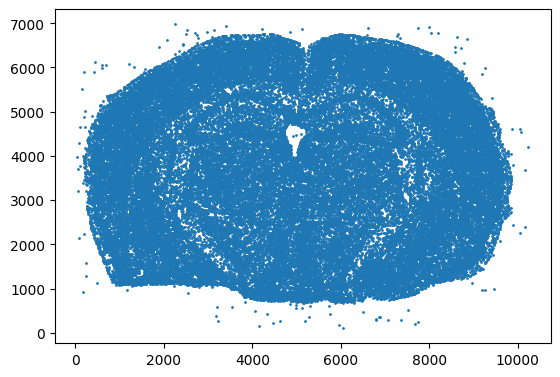

In [5]:
_ = plt.scatter(coordinate_df.loc[::1000, "x"], coordinate_df.loc[::1000, "y"], s=1)
plt.gca().set_aspect('equal', adjustable='box')


## Compute & Visualize coherence map

In [6]:
integrity, signal, visualizer = ovrlp.compute_coherence_map(
    df=coordinate_df, cell_diameter=10, n_expected_celltypes=30
)

Running vertical adjustment
Analyzing in 3d mode:
determining pseudocells:
Searching within x:(1, 5138), y:(2, 3519), n_molecules:62384369
Using bandwidth: 2.0, min_expression: 1.0, min_pixel_distance: 9.0
found 62341 pseudocells
sampling expression:


Wfs1: 100%|██████████| 248/248 [29:01<00:00,  7.02s/it]        


Modeling 30 pseudo-celltype clusters


/dh-projects/ag-ishaque/analysis/malta/envs/envs/ovrlpy/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:3596: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/dh-projects/ag-ishaque/analysis/malta/envs/envs/ovrlpy/lib/python3.12/site-packages/numpy/_core/_methods.py:130: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


Creating signal integrity map:
[    0  1027  2055  3082  4110  5138  6165  7193  8220  9248 10276] [   0 1005 2010 3015 4021 5026 6031 7037]


100%|██████████| 70/70 [27:55<00:00, 23.93s/it]


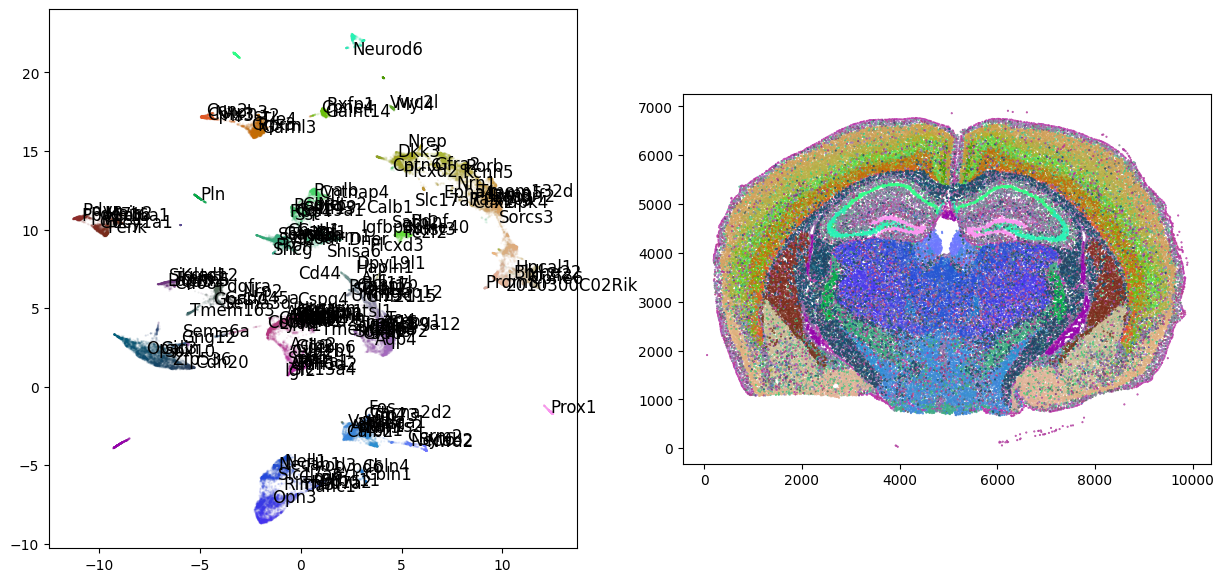

In [7]:
visualizer.plot_fit()

11


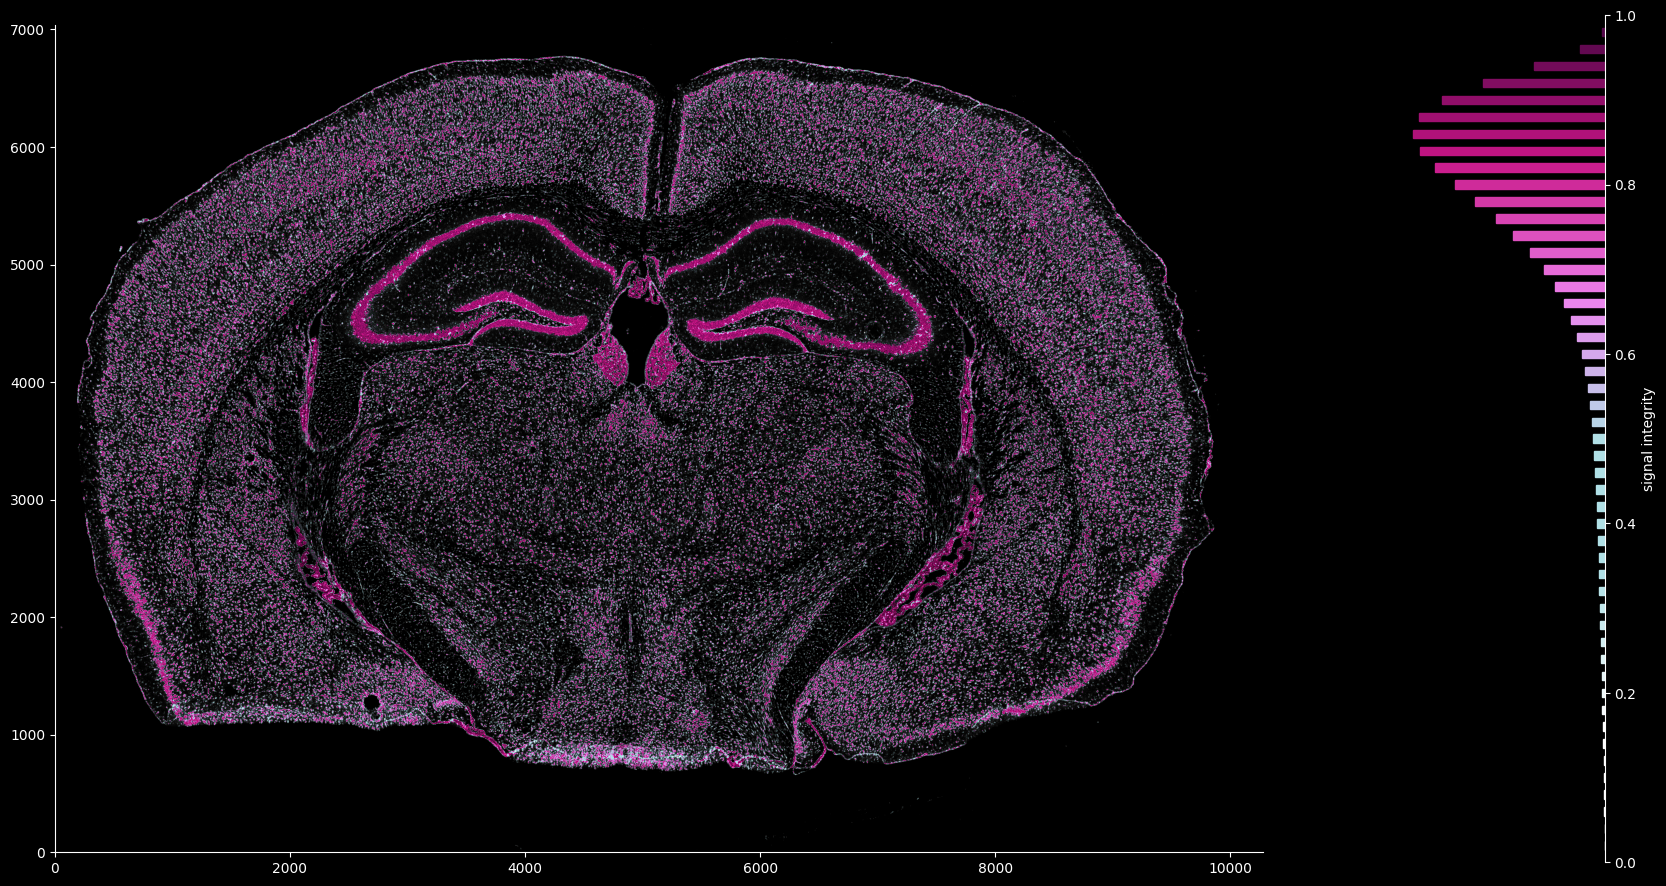

In [8]:
fig, ax = ovrlp.plot_signal_integrity(integrity, signal, signal_threshold=3)

## Doublet probability 

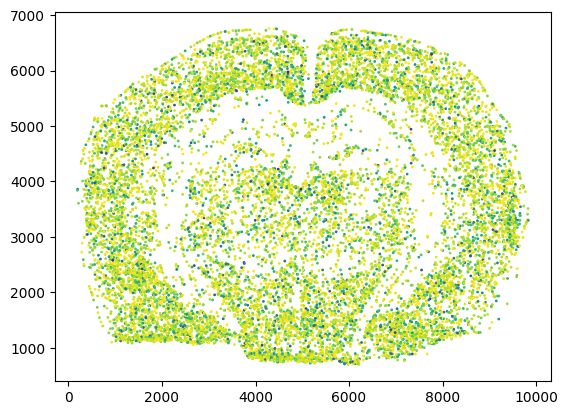

In [8]:
doublet_df = ovrlp.detect_doublets(
    integrity, signal, signal_cutoff=4, coherence_sigma=3
)

_ = plt.scatter(
    doublet_df["x"], doublet_df["y"], c=doublet_df["integrity"], s=1, cmap="viridis_r"
)
plt.gca().set_aspect('equal', adjustable='box')
plt.colorbar(_)

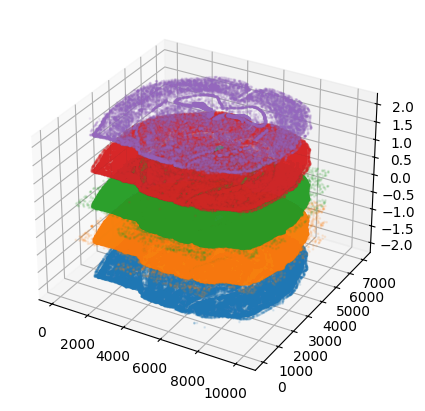

In [9]:
plt.figure(figsize=(20, 5))

ax = plt.subplot(111, projection="3d")

for i in range(-2, 3):
    subset = coordinate_df[(coordinate_df.z - coordinate_df.z_delim).between(i, i + 1)]

    ax.scatter(
        subset.x[::100],
        subset.y[::100],
        np.zeros(1 + (len(subset) // 100)) + i,
        s=1,
        alpha=0.1,
    )

In [10]:
adata = ad.read_mtx(data_folder_path / "cell_feature_matrix/matrix.mtx").T
adata.var = pd.read_csv(
    data_folder_path / "cell_feature_matrix/features.tsv",
    header=None,
    index_col=1,
    names=["gene_id", "gene", "feature_type"],
    sep="\t",
)
adata.obs = (
    pd.read_parquet(data_folder_path / "cells.parquet")
    .assign(cell_id=lambda df: df["cell_id"].astype(str))
    .set_index("cell_id")
)
adata.obs[["x_centroid", "y_centroid"]].head()

# Filter out empty cells:
# adata = adata[adata.X.sum(axis=1)>50]

x_centroid   y_centroid
cell_id                          
1        1557.532239  2528.022437
2        1560.669312  2543.632678
3        1570.462885  2530.810461
4        1573.927734  2546.454529
5        1581.344379  2557.024951

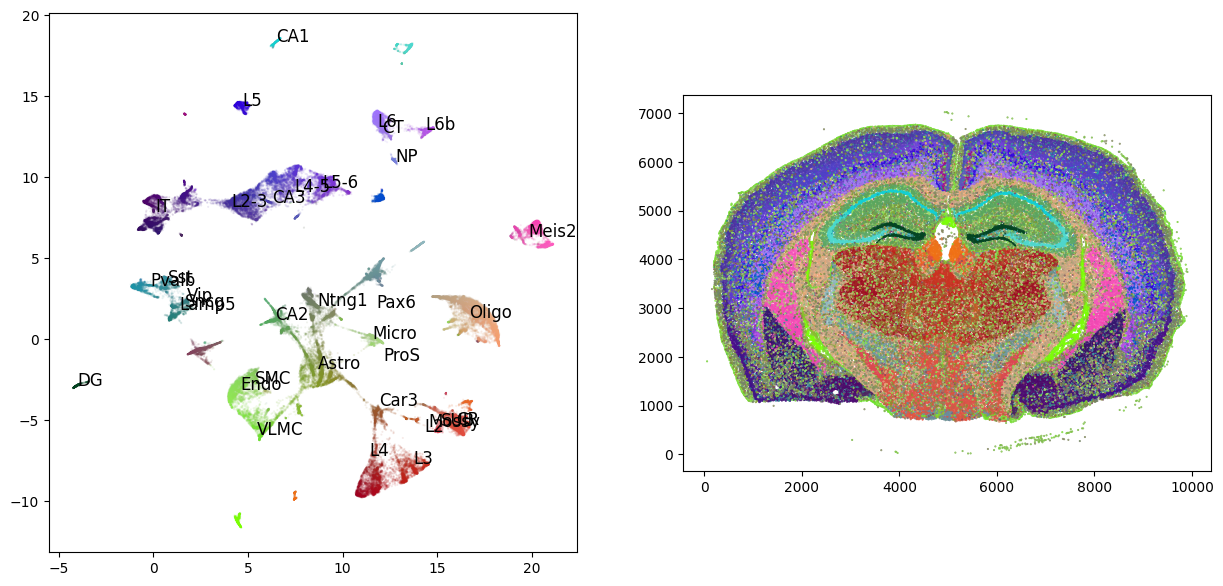

In [11]:
signatures = pd.read_csv(signature_matrix_file, index_col=0)

signatures = (
    signatures.T.groupby(lambda x: x.split("_")[1].split(" ")[0].split("-")[0])
    .apply(lambda x: x.mean(0))
    .T
).loc[signatures.index[signatures.index.isin(visualizer.genes)]]


signatures.columns = signatures.columns.str.replace("/", "-")

visualizer.fit_signatures(signatures)

visualizer.plot_fit()

/dh-projects/ag-ishaque/analysis/muellni/envs/ovrlpy/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(


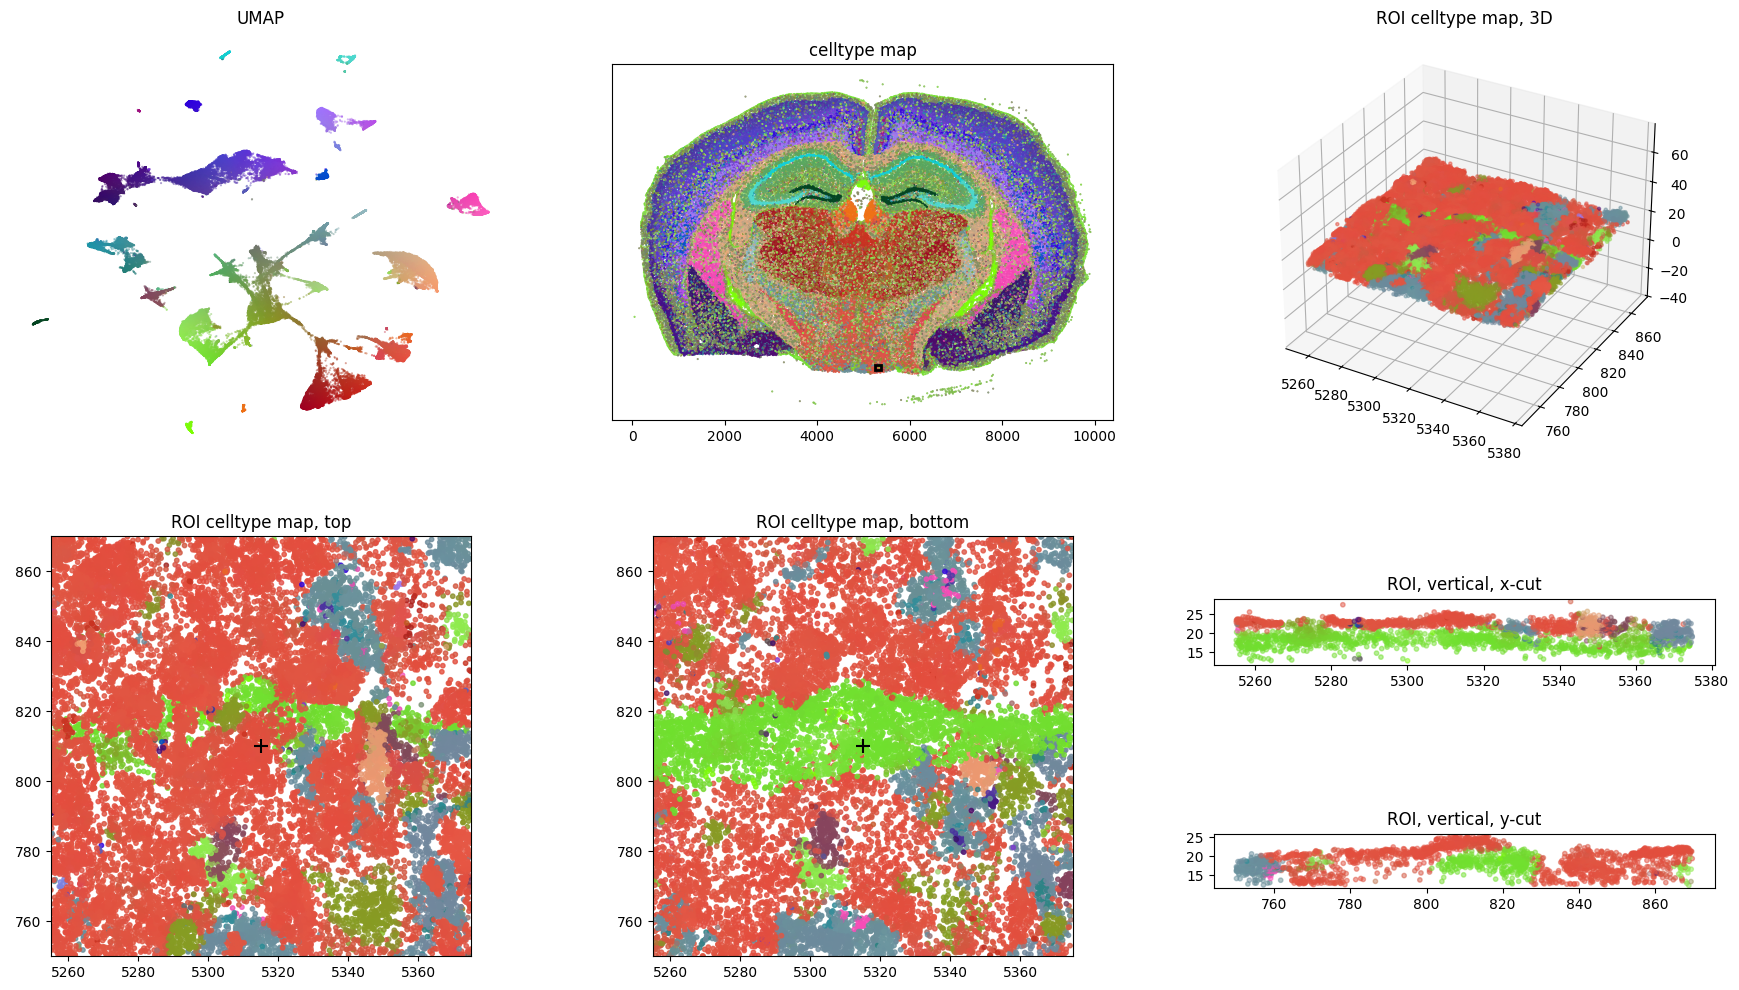

In [12]:
window_size = 60
doublet_case = 0

x, y = doublet_df.loc[doublet_case, ["x", "y"]]

subsample = visualizer.subsample_df(x, y, coordinate_df, window_size=window_size)
subsample_embedding, subsample_embedding_color = visualizer.transform(subsample)

visualizer.plot_instance(
    subsample, subsample_embedding_color, x, y, window_size=window_size, rasterized=True
)

We can save the visualizer object to file for later use ...

In [13]:
visualizer.save(result_folder / "Xenium-text-visualizer.vis")

/dh-projects/ag-ishaque/analysis/muellni/envs/ovrlpy/lib/python3.12/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


... and easily reload it if needed.

In [14]:
vis = ovrlp.load_visualizer(result_folder / "Xenium-text-visualizer.vis")